In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [63]:
milk_data = pd.read_csv("monthly-milk-production.csv", index_col="Month")
milk_data.index = pd.to_datetime(milk_data.index)

#  train and test split
data_train = milk_data.head(len(milk_data) - 12)
data_test = milk_data.tail(12)

# Scale data by using MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(data_train)
# shouldn not fit into test_data, otherwise we know the data
test_scaled = scaler.transform(data_test)

In [21]:
def next_batch(training_data, steps=12):
    # random starting point
    rand_start = np.random.randint(0, len(training_data) - steps)
    
    y_batch = np.array(training_data[rand_start:(rand_start + steps + 1)]).reshape(1, steps + 1)
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [ ]:
num_inputs = 1
num_time_step = 12
num_neuraon_per_layer = 150
num_output = 1
learning_rate = 0.001
num_iteration = 4000
batch_size = 1
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=[None, num_time_step, num_inputs])
y = tf.placeholder(dtype=tf.float32, shape=[None, num_time_step, num_inputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neuraon_per_layer, activation=tf.nn.relu), num_output)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(y - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_iteration):
        x_batch, y_batch = next_batch(training_data=train_scaled)
        
        sess.run(train, feed_dict={X:x_batch, y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:x_batch, y:y_batch})
            print (iteration, "\tMSE:", mse)

    saver.save(sess, "./RNN_With_Real_Data")

0 	MSE: 0.0533958
100 	MSE: 0.0373013
200 	MSE: 0.0556412
300 	MSE: 0.0383744
400 	MSE: 0.00706183
500 	MSE: 0.0174182
600 	MSE: 0.0116466
700 	MSE: 0.00665787
800 	MSE: 0.00643335
900 	MSE: 0.00963745
1000 	MSE: 0.00921388
1100 	MSE: 0.00674248
1200 	MSE: 0.00892923
1300 	MSE: 0.00918238
1400 	MSE: 0.00822948
1500 	MSE: 0.0055818
1600 	MSE: 0.00722552
1700 	MSE: 0.00702582
1800 	MSE: 0.00899383
1900 	MSE: 0.00851852
2000 	MSE: 0.00811483
2100 	MSE: 0.00609353
2200 	MSE: 0.0113428
2300 	MSE: 0.00689712
2400 	MSE: 0.00788853
2500 	MSE: 0.0118268
2600 	MSE: 0.00999158
2700 	MSE: 0.00754471


In [ ]:
type(outputs)

In [73]:
with tf.Session() as sess:
    saver.restore(sess, "./RNN_With_Real_Data")
    
    train_seed = list(train_scaled[-12:])
    print (train_seed)
    for i in range(12):
        x_batch = np.array(train_seed[-12:]).reshape(1, num_time_step, 1)
        y_pred = sess.run(outputs, feed_dict={X:x_batch})
        train_seed.append(y_pred[0, -1, 0])
train_seed

results = scaler.inverse_transform(np.array(train_seed[-12:]).reshape(12, 1))
data_test["Generate"] = results
print(data_test)

INFO:tensorflow:Restoring parameters from ./RNN_With_Real_Data
[array([ 0.66105769]), array([ 0.54086538]), array([ 0.80769231]), array([ 0.83894231]), array([ 1.]), array([ 0.94711538]), array([ 0.85336538]), array([ 0.75480769]), array([ 0.62980769]), array([ 0.62259615]), array([ 0.52884615]), array([ 0.625])]
                     Milk Production    Generate
Month                                           
1975-01-01 01:00:00            834.0  818.253052
1975-02-01 01:00:00            782.0  836.553223
1975-03-01 01:00:00            892.0  891.526062
1975-04-01 01:00:00            903.0  946.614380
1975-05-01 01:00:00            966.0  973.725586
1975-06-01 01:00:00            937.0  943.118591
1975-07-01 01:00:00            896.0  882.808533
1975-08-01 01:00:00            858.0  826.513184
1975-09-01 01:00:00            817.0  781.059631
1975-10-01 01:00:00            827.0  755.019653
1975-11-01 01:00:00            797.0  755.065186
1975-12-01 01:00:00            843.0  772.562073

/anaconda2/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


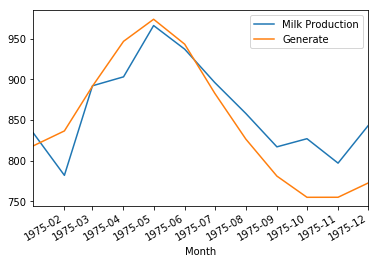

In [74]:
data_test.plot()